## Keras RNN weather prediction in Rostov-on-Don

In [1]:
import os

import theano
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Using Theano backend.


### Подготовим данные для обучения

In [2]:
data = open('34731.dat').readlines()

meteo_x = []
meteo_y = []

for d in data[42006:]:
    wmo = int(d[0:5])
    year = int(d[5:9])
    month = int(d[9:11])
    day = int(d[11:13])
    hour = int(d[13:15])
    # Humidity
    rh = int(d[15:18])
    # Height of the base of the lowest cloud
    hcld = int(d[43:45])
    # Dew point
    tdew = int(d[47:50])
    # Cloud amount
    tcld = int(d[53:55])
    # Wind direction
    wdir = int(d[61:63])
    # Wind speed
    wspd = int(d[64:66])
    # Air pressure
    stap = float(d[73:78])/10
    # Past weather code
    w = int(d[83:84])
    # Air temperature
    airt = float(d[89:93]) / 10 if d[89:93] != '9999' else 0.0
    if hour:
        meteo_x.append(airt)       
        meteo_y.append(airt)

meteo_x = np.array(meteo_x)
meteo_y = np.array(meteo_y)

print(len(meteo_x), len(meteo_y))

68605 68605


### Задаем параметры  обучающих векторов и поседовательности

In [3]:
seq_length = 8
seq_out = 1

### Построим обучающие выборки

In [4]:
train_x_size = int(len(meteo_x) * 0.5)
train_y_size = int(len(meteo_y) * 0.5)

train_x, test_x = np.array(meteo_x[0:train_x_size]), np.array(meteo_x[train_x_size:len(meteo_x)])
train_y, test_y = np.array(meteo_y[0:train_y_size]), np.array(meteo_y[train_y_size:len(meteo_y)])

train_x_seq = []
train_y_seq = []

test_x_seq = []
test_y_seq = []

for i in range(len(train_x) - seq_length):
    train_x_seq.append([train_x[i:i + seq_length]])
    
for i in range(len(train_y) - seq_length * 2):
    train_y_seq.append([train_y[i + seq_length:i + seq_length + seq_out]])
    
for i in range(len(test_x) - seq_length):
    test_x_seq.append([test_x[i:i + seq_length]])
    
for i in range(len(test_y) - seq_length * 2):
    test_y_seq.append([test_y[i + seq_length:i + seq_length + seq_out]])
    
train_x_seq = np.array(train_x_seq).reshape((len(train_x_seq), 1, seq_length))
train_y_seq = np.array(train_y_seq).reshape((len(train_y_seq), seq_out))
test_x_seq = np.array(test_x_seq).reshape((len(test_x_seq), 1, seq_length))
test_y_seq = np.array(test_y_seq).reshape((len(test_y_seq), seq_out))

train_x_seq = train_x_seq[:2000]
train_y_seq = train_y_seq[:2000]

test_x_seq = test_x_seq[:500]
test_y_seq = test_y_seq[:500]

print(train_x_seq[0])
print(train_y_seq[0])

print(len(train_x_seq), len(train_y_seq))

[[ 0.2  0.5  3.9  7.8  7.3  6.3  6.1  2.2]]
[ 2.2]
2000 2000


### Строим модель нейронной сети

In [5]:
%%time
model = Sequential()
model.add(LSTM(64, input_shape = (1, seq_length), activation='relu'))
model.add(Dense(seq_out))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Wall time: 850 ms


### Обучаем нейронную сеть и сохраняем

In [6]:
%%time
history = model.fit(train_x_seq, train_y_seq, validation_data=(test_x_seq, test_y_seq), epochs=50, batch_size=32, verbose=2)

model.save_weights('weights.net')

Train on 2000 samples, validate on 500 samples
Epoch 1/50
0s - loss: 62.4356 - acc: 0.0090 - val_loss: 7.9326 - val_acc: 0.0120
Epoch 2/50
0s - loss: 7.2015 - acc: 0.0175 - val_loss: 4.8363 - val_acc: 0.0080
Epoch 3/50
0s - loss: 5.5532 - acc: 0.0275 - val_loss: 3.9327 - val_acc: 0.0140
Epoch 4/50
0s - loss: 4.9735 - acc: 0.0270 - val_loss: 3.7632 - val_acc: 0.0080
Epoch 5/50
0s - loss: 4.6560 - acc: 0.0305 - val_loss: 3.5034 - val_acc: 0.0180
Epoch 6/50
0s - loss: 4.3827 - acc: 0.0320 - val_loss: 3.3952 - val_acc: 0.0180
Epoch 7/50
0s - loss: 4.2065 - acc: 0.0345 - val_loss: 3.7129 - val_acc: 0.0120
Epoch 8/50
0s - loss: 4.2164 - acc: 0.0290 - val_loss: 3.5618 - val_acc: 0.0180
Epoch 9/50
0s - loss: 3.9747 - acc: 0.0365 - val_loss: 3.4122 - val_acc: 0.0160
Epoch 10/50
0s - loss: 3.8838 - acc: 0.0320 - val_loss: 3.4963 - val_acc: 0.0140
Epoch 11/50
0s - loss: 3.9057 - acc: 0.0325 - val_loss: 3.1579 - val_acc: 0.0220
Epoch 12/50
0s - loss: 3.7794 - acc: 0.0330 - val_loss: 3.0189 - val_a

### Строим график обучения

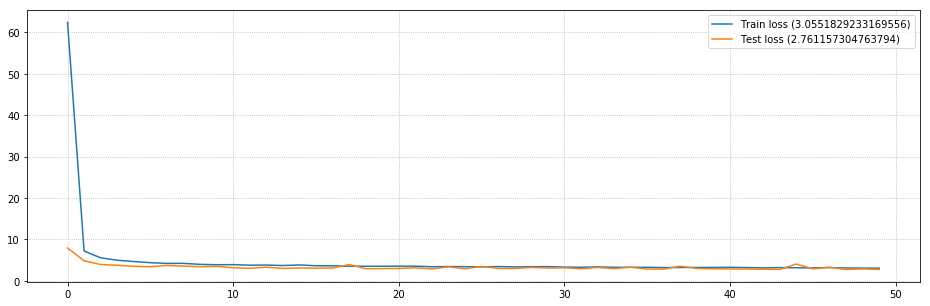

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['Train loss ({})'.format(history.history['loss'][-1]), \
           'Test loss ({})'.format(history.history['val_loss'][-1])])
ax.grid(ls=':')
plt.show()

### Загружаем нейронную сеть из файла

In [8]:
model.load_weights('weights.net')

### Предсказываем данные

In [9]:
real_test_data = [20.1, 18.3, 20.1, 26, 28.8, 31.6, 32.1, 26.7, 25.2, 22.5, 21, 28.6, 31.5, 33.4, 32.9, 28.4, 25.9, 24.7, 23.7, 29.4, 34, 34.5, 34.5, 30.2, 27.4, 24.1, 25, 35.2, 36.3, 36.6, 32.1, 25.7, 25.3, 24.8, 33.9, 36.2, 37.1, 36.6, 32.5, 29.7, 25.8, 26.5, 32.7, 36.5, 37.4, 32.5, 29.2, 27.1, 25.8, 29.2, 35, 37.9, 36, 31.3, 31.1, 27.1, 26.3, 29.2, 35.3, 38.4, 38.3, 29.2, 27.4, 25.1, 24.8, 27, 32.8, 35.5, 33.5, 28.6, 25.3, 23.8, 21.9, 25.7, 29.9, 31.4, 30.2, 35, 32.6, 25.9, 23.2, 22.8, 24.7, 30.9, 32.4, 30.8, 23.3, 22.4, 19, 23.6, 29.7, 32.5, 31.3, 28, 23.1, 20.8, 25.6, 33, 32.1, 28.5, 25.3, 23.2, 21.7, 25.1, 31.2, 33.2, 31.9, 26.1, 25.9, 22.5, 21, 25.7, 31.3, 32.2, 26.4, 23.8, 22.3, 26.5, 32.8, 33.1, 30.1, 25, 23.6, 21.9, 20.1, 26.6, 31.6, 32.8, 31.6, 25.8, 23.7, 21.9, 20.7, 18.7, 27.5, 31, 24.8, 22.8, 22.1, 20.9, 20.2, 24.1, 23.6, 21.4, 21, 18.7, 16.3]

real_seq_y = []
predicted_seq_y = []

for i in range(len(real_test_data) - seq_length):
    real_test_x = real_test_data[i:i + seq_length]
    real_test_y = real_test_data[i + seq_length: i + seq_length + seq_out]

    predicted_test_y = model.predict(np.array([[real_test_x]]))
    predicted_test_y = np.squeeze(predicted_test_y)
    
    real_seq_y.append(real_test_y)
    predicted_seq_y.append(predicted_test_y)
    
real_seq_y = np.array(real_seq_y)
predicted_seq_y = np.array(predicted_seq_y)

### Определяем погрешность работы сети на реальных данных

In [10]:
delta = np.mean(np.abs(np.squeeze(real_seq_y.reshape(1, 139)) - np.squeeze(predicted_seq_y.reshape(1, 139))))
print('Средняя погрешность определения температуры: {}'.format(delta))

Средняя погрешность определения температуры: 2.0547684100034425


### Строим графики валидации на тестовой выборке

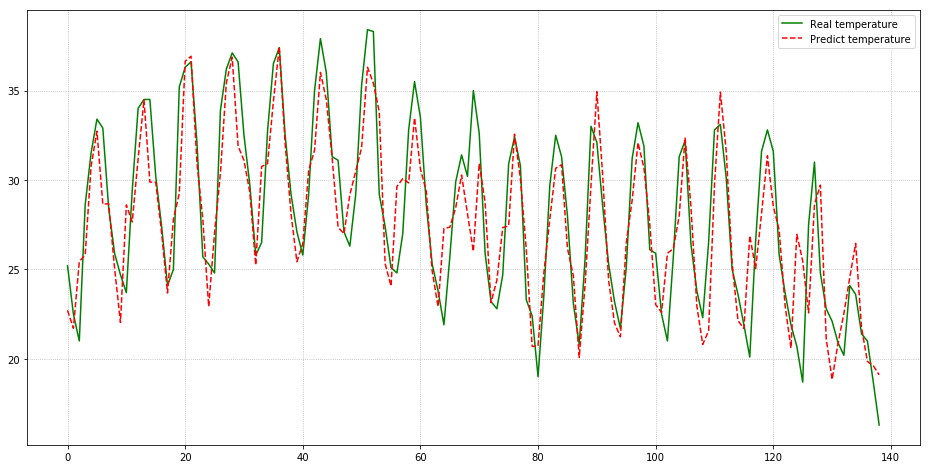

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(real_seq_y, 'g-')
ax.plot(predicted_seq_y, 'r--')
ax.legend(['Real temperature', 'Predict temperature'])
ax.grid(ls=':')
plt.show()